In [ ]:
# 1. 날짜 + 시간 → 세로형 변환
df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량(MWh)')
df_long['시간'] = df_long['시간'].str.replace('시', '').astype(int)

# 2. 날짜 + 시간 합쳐서 datetime 생성
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간'] - 1, unit='h')

# 3. Prophet용 포맷으로 변환
df_prophet = df_long[['일시', '수요량(MWh)']].rename(columns={'일시': 'ds', '수요량(MWh)': 'y'})


In [ ]:
# 반드시 이 순서로 실행
!pip install scikit-learn==1.2.2 --quiet
!pip install -U "u8darts[all]" --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 122.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 124.2 MB/s eta 0:00:00


In [ ]:
from darts.models import DLinearModel
from darts import TimeSeries


In [ ]:
# 1. 나눔 폰트 설치
!apt-get -qq update
!apt-get -qq install -y fonts-nanum

# 2. 런타임 내 폰트 등록
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 3. 설치된 나눔고딕 경로 확인 및 등록
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplre9hhrt/5bq0noqi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplre9hhrt/_fxjg6s9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82001', 'data', 'file=/tmp/tmplre9hhrt/5bq0noqi.json', 'init=/tmp/tmplre9hhrt/_fxjg6s9.json', 'output', 'file=/tmp/tmplre9hhrt/prophet_modelek30i3xx/prophet_model-20250601175630.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:56:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:56:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✅ Prophet 예측 결과 → MAE: 8925.82, RMSE: 9184.79


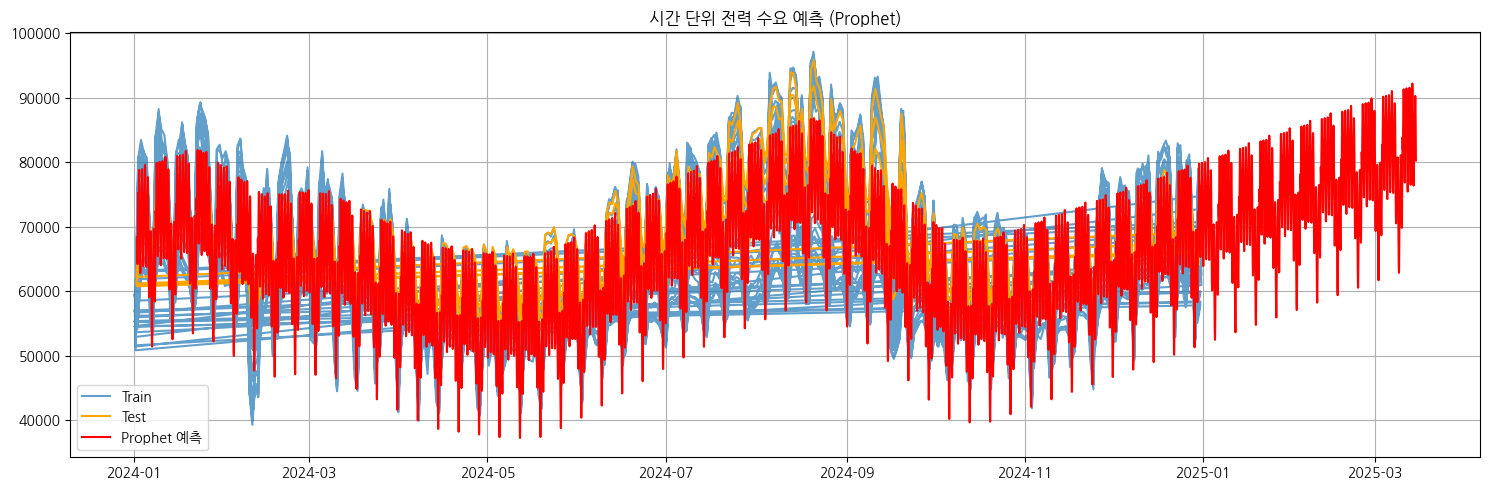

In [ ]:
# Prophet 설치
# !pip install prophet --quiet

import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. 데이터 불러오기 및 전처리 (wide → long)
file_path = '/content/drive/MyDrive/ColabNotebooks/한국전력거래소_시간별 전국 전력수요량_20241231.csv'
df = pd.read_csv(file_path, encoding='cp949')

# melt로 세로형 변환
df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량(MWh)')
df_long['시간'] = df_long['시간'].str.replace('시', '').astype(int)
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간'] - 1, unit='h')

# Prophet 형식으로 변환
df_prophet = df_long[['일시', '수요량(MWh)']].rename(columns={'일시': 'ds', '수요량(MWh)': 'y'})

# 2. train/test 분할 (80:20)
split_idx = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:split_idx]
test_df = df_prophet.iloc[split_idx:]

# 3. Prophet 모델 학습
model = Prophet(daily_seasonality=True)
model.fit(train_df)

# 4. 미래 프레임 생성 및 예측 수행
future = model.make_future_dataframe(periods=len(test_df), freq='h')  # 시간 단위
forecast = model.predict(future)

# 5. 예측값 병합 및 평가용 유효 구간 추출
forecast_result = forecast[['ds', 'yhat']]
merged = pd.merge(test_df, forecast_result, on='ds', how='left')
valid_rows = merged.dropna(subset=['y', 'yhat'])

# 6. 평가 지표 계산
mae = mean_absolute_error(valid_rows['y'], valid_rows['yhat'])
rmse = mean_squared_error(valid_rows['y'], valid_rows['yhat']) ** 0.5
print(f"✅ Prophet 예측 결과 → MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# 7. 시각화 (예측선은 Test 기간만 보여줌)
forecast_test_only = forecast[forecast['ds'] >= test_df['ds'].min()]

plt.figure(figsize=(15,5))
plt.plot(train_df['ds'], train_df['y'], label='Train', alpha=0.7)
plt.plot(test_df['ds'], test_df['y'], label='Test', color='orange')
plt.plot(forecast_test_only['ds'], forecast_test_only['yhat'], label='Prophet 예측', color='red')
plt.legend()
plt.title("시간 단위 전력 수요 예측 (Prophet)")
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-5-18a397a14dfb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_rows['월'] = valid_rows['ds'].dt.to_period('M')  # 월 단위로 변환


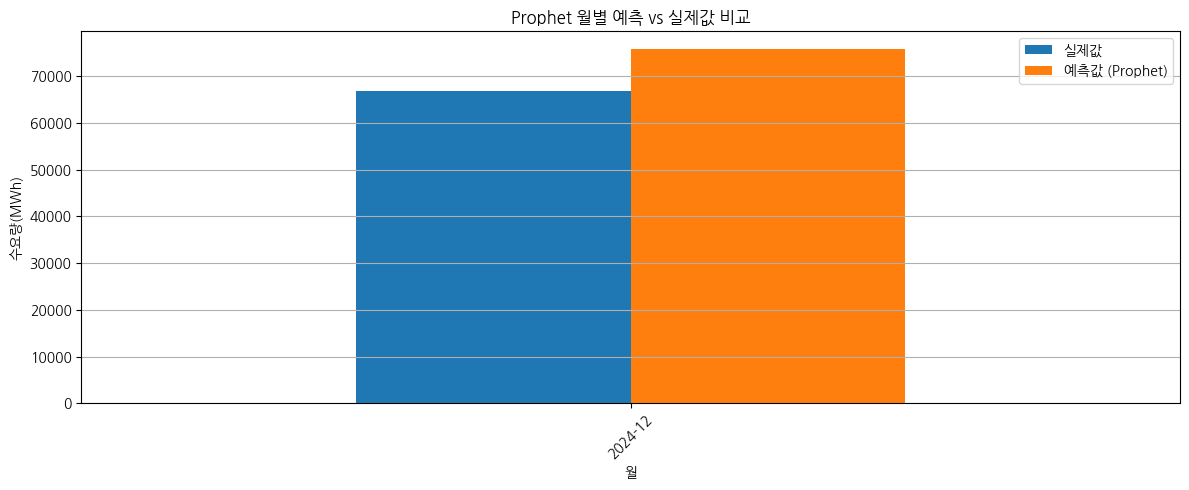

In [ ]:
# 1. 예측값 병합 (test_df + forecast → merged)
forecast_result = forecast[['ds', 'yhat']]
merged = pd.merge(test_df, forecast_result, on='ds', how='left')
valid_rows = merged.dropna(subset=['y', 'yhat'])

# 2. 월 단위로 그룹화해서 평균 수요량 비교
valid_rows['월'] = valid_rows['ds'].dt.to_period('M')  # 월 단위로 변환

monthly_comparison = valid_rows.groupby('월')[['y', 'yhat']].mean()
monthly_comparison = monthly_comparison.rename(columns={'y': '실제값', 'yhat': '예측값 (Prophet)'})

# 3. 시각화
monthly_comparison.plot(kind='bar', figsize=(12,5), title="Prophet 월별 예측 vs 실제값 비교", ylabel='수요량(MWh)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
!pip install u8darts[all]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 727 K  | train
7 | linear_trend    | Linear           | 727 K  | train
----------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

📊 DLinear 계절 예측 RMSE: 6402.68


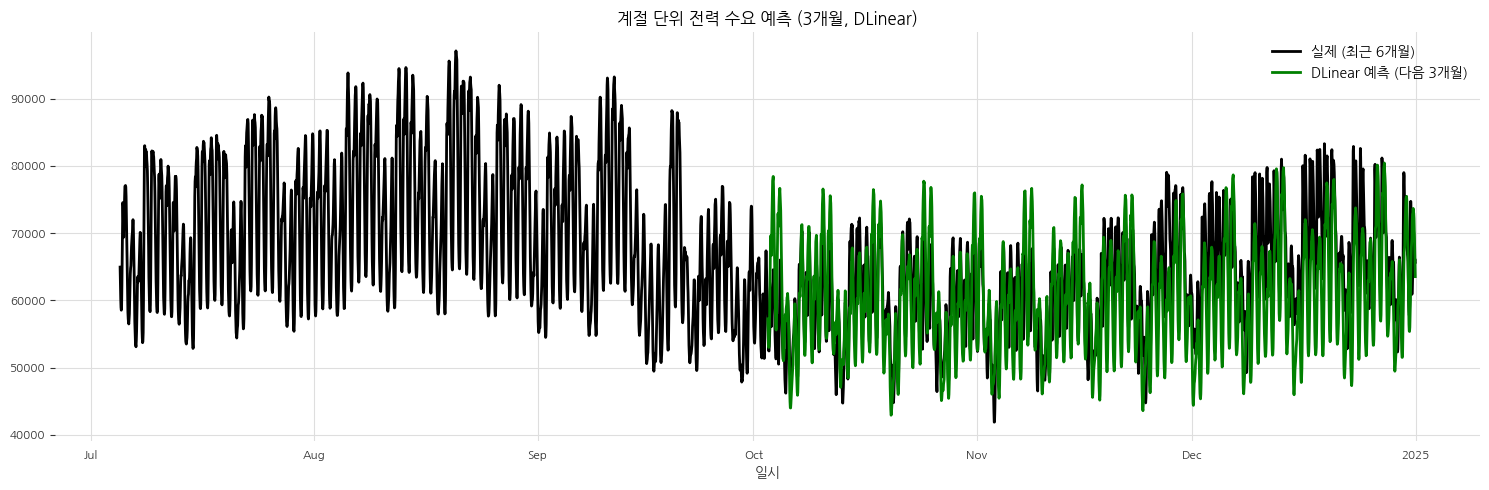

In [ ]:
# 1. 패키지 임포트
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import DLinearModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler
from darts.metrics import rmse, mase

# 2. 데이터 불러오기 및 전처리
file_path = '/content/drive/MyDrive/ColabNotebooks/한국전력거래소_시간별 전국 전력수요량_20241231.csv'
df = pd.read_csv(file_path, encoding='cp949')

# wide → long 변환
df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량')
df_long['시간'] = df_long['시간'].str.replace('시', '').astype(int)
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간'] - 1, unit='h')

# TimeSeries 변환
series = TimeSeries.from_dataframe(df_long, time_col='일시', value_cols='수요량')

# 3. 스케일링
scaler = Scaler(StandardScaler())
series_scaled = scaler.fit_transform(series)

# 4. train/test 분할 (마지막 3개월 = 약 2160시간 테스트)
train, test = series_scaled[:-2160], series_scaled[-2160:]

# 5. DLinear 모델 정의 및 학습
model = DLinearModel(input_chunk_length=336, output_chunk_length=2160, random_state=42)
model.fit(train)

# 6. 예측
forecast = model.predict(n=2160)

# 7. 역스케일링
forecast_inv = scaler.inverse_transform(forecast)
test_inv = scaler.inverse_transform(test)

# 8. 평가 지표
rmse_val = rmse(test_inv, forecast_inv)
print(f"📊 DLinear 계절 예측 RMSE: {rmse_val:.2f}")

# 9. 시각화
plt.figure(figsize=(15,5))
series[-4320:].plot(label='실제 (최근 6개월)')
forecast_inv.plot(label='DLinear 예측 (다음 3개월)', color='green')
plt.title("계절 단위 전력 수요 예측 (3개월, DLinear)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | decomposition   | _SeriesDecomp    | 0      | train
6 | linear_seasonal | Linear           | 727 K  | train
7 | linear_trend    | Linear           | 727 K  | train
----------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

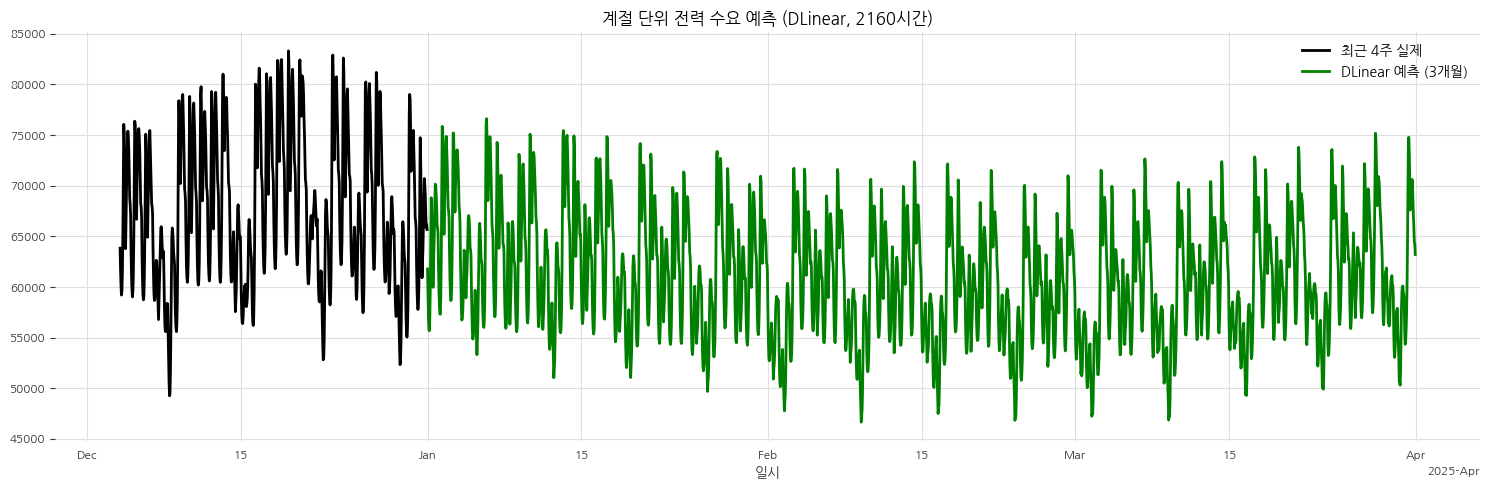

In [ ]:
# 필요한 패키지
from darts import TimeSeries
from darts.models import DLinearModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from darts.metrics import rmse

# 1. 데이터 불러오기 및 전처리
file_path = "/content/drive/MyDrive/ColabNotebooks/한국전력거래소_시간별 전국 전력수요량_20241231.csv"
df = pd.read_csv(file_path, encoding='cp949')

# wide → long 변환
df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량')
df_long['시간'] = df_long['시간'].str.replace('시', '').astype(int)
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간'] - 1, unit='h')

# Darts TimeSeries 변환
series = TimeSeries.from_dataframe(df_long, time_col='일시', value_cols='수요량')

# 2. 스케일링
scaler = Scaler(StandardScaler())
series_scaled = scaler.fit_transform(series)

# 3. 예측 범위 설정 (3개월 = 2160시간)
forecast_horizon = 2160

# 4. DLinear 모델 정의 (torch_device 제거됨)
model = DLinearModel(
    input_chunk_length=336,
    output_chunk_length=forecast_horizon,
    random_state=42
)

# 5. 모델 학습
model.fit(series_scaled)

# 6. 예측
forecast = model.predict(n=forecast_horizon)

# 7. 역스케일링
forecast_inv = scaler.inverse_transform(forecast)

# 8. 시각화
plt.figure(figsize=(15, 5))
series[-336*2:].plot(label='최근 4주 실제')
forecast_inv.plot(label='DLinear 예측 (3개월)', color='green')
plt.title("계절 단위 전력 수요 예측 (DLinear, 2160시간)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 572    | train
-------------------------------------------------------------
572       Trainable params
0         Non-trainable params
572       Total params
0.002     Total estimated m

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

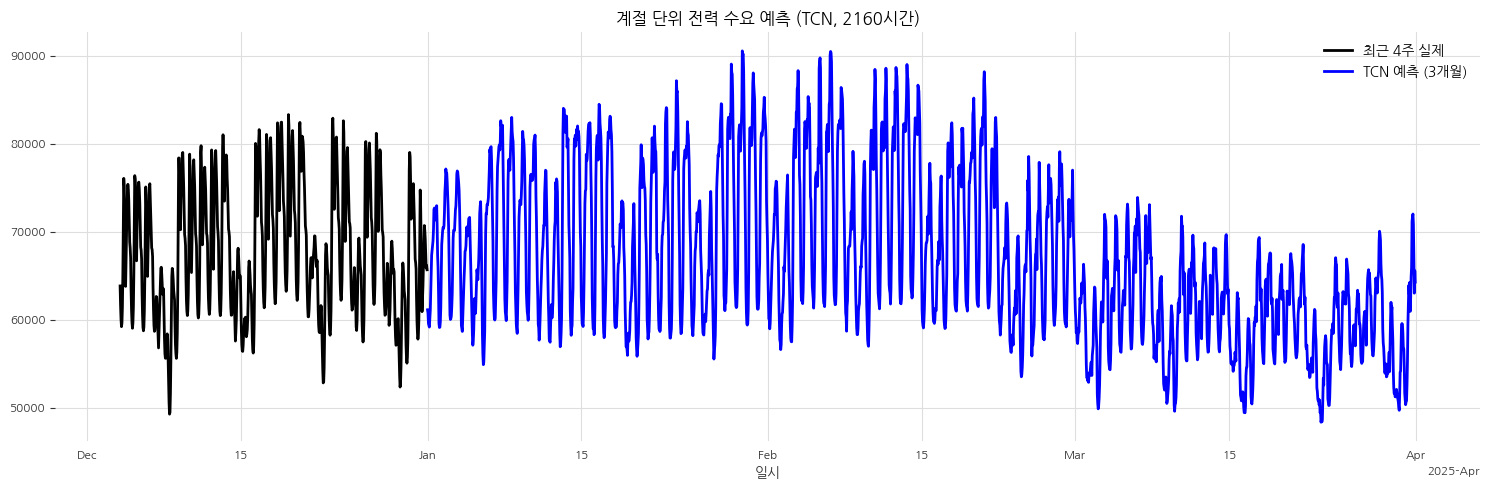

In [ ]:
# TCN 기반 3개월 예측 (Darts)

from darts.models import TCNModel
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기 및 전처리
file_path = "/content/drive/MyDrive/ColabNotebooks/한국전력거래소_시간별 전국 전력수요량_20241231.csv"
df = pd.read_csv(file_path, encoding='cp949')

df_long = df.melt(id_vars='날짜', var_name='시간', value_name='수요량')
df_long['시간'] = df_long['시간'].str.replace('시', '').astype(int)
df_long['일시'] = pd.to_datetime(df_long['날짜']) + pd.to_timedelta(df_long['시간'] - 1, unit='h')

series = TimeSeries.from_dataframe(df_long, time_col='일시', value_cols='수요량')

# 2. 스케일링
scaler = Scaler(StandardScaler())
series_scaled = scaler.fit_transform(series)

# 3. TCN 모델 정의 (수정됨)
input_chunk = 3000               # ✅ input > output
forecast_horizon = 2160          # 3개월 예측

model = TCNModel(
    input_chunk_length=input_chunk,
    output_chunk_length=forecast_horizon,
    n_epochs=300,
    random_state=42
)

# 4. 모델 학습
model.fit(series_scaled)

# 5. 예측
forecast = model.predict(n=forecast_horizon)

# 6. 역스케일링
forecast_inv = scaler.inverse_transform(forecast)

# 7. 시각화
plt.figure(figsize=(15, 5))
series[-336*2:].plot(label='최근 4주 실제')
forecast_inv.plot(label='TCN 예측 (3개월)', color='blue')
plt.title("계절 단위 전력 수요 예측 (TCN, 2160시간)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
